In [11]:
import numpy as np
from scipy import io
from scipy.stats import pearsonr
from scipy.signal import detrend
from scipy.signal import convolve
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from nilearn.image import get_data
from nilearn.glm.first_level import spm_hrf,compute_regressor
from sklearn.linear_model import Ridge


In [4]:
# Empirical BLOCK design, HCP Working Memory, TR = 0.72
data = io.loadmat('./data/03_BD_Sub_01_ROI_01.mat')

# Repetition time [s]
TR = 0.72

# Preprocessed BOLD time-series length
N = len(data['preproc_BOLD_signal'])

# Microtime resolution
NT = 16

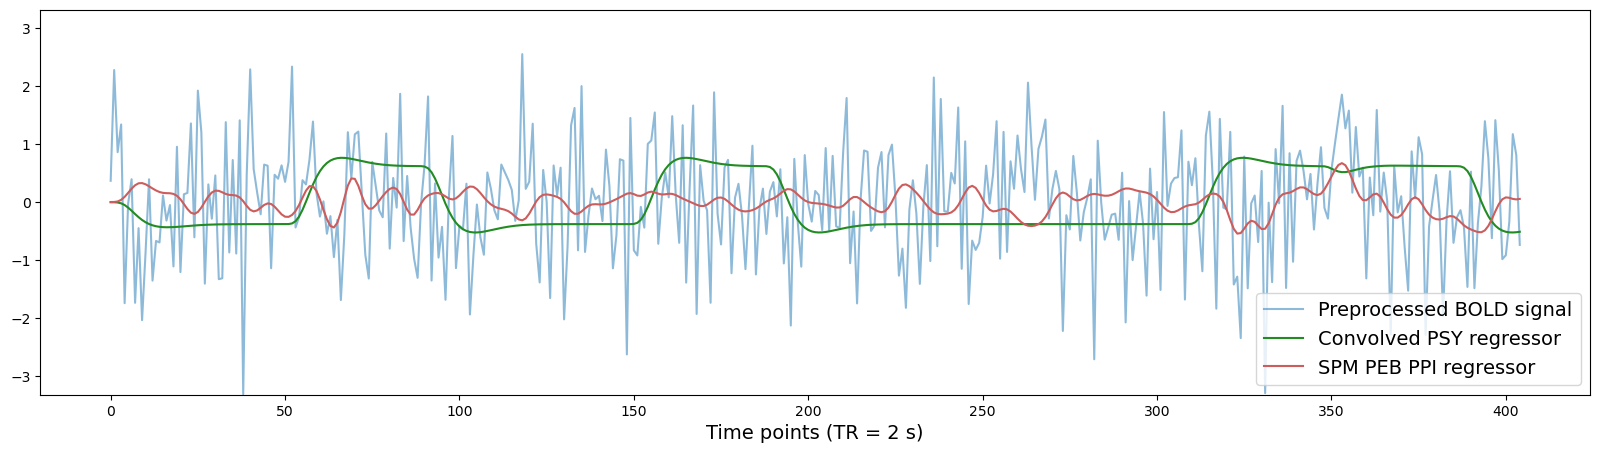

In [5]:
figure(figsize=(20, 5))
plt.plot(data['preproc_BOLD_signal'], label = 'Preprocessed BOLD signal', alpha = 0.5)
plt.plot(data['psy_convolved'], c = 'forestgreen', label = 'Convolved PSY regressor')
plt.plot(data['spm_ppi'], c = 'indianred', label = 'SPM PEB PPI regressor')
plt.legend(fontsize = 14)
plt.ylim(-1.3*np.max(data['preproc_BOLD_signal']), 1.3*np.max(data['preproc_BOLD_signal']))
plt.xlabel('Time points (TR = 2 s)', fontsize = 14)
plt.show()

In [6]:
def dctmtx(N,K):
    n = np.array((range(0,N))).T
    C = np.zeros((n.shape[0],K))
    C[:,0] = np.ones(n.shape[0])/np.sqrt(N)
    for k in range(1,K):
        C[:,k] = np.sqrt(2/N)*np.cos(np.pi*(2*n)*(k)/(2*N))
    return C

In [7]:
# Create cosine basis set
xb = dctmtx(NT*N+128,N)


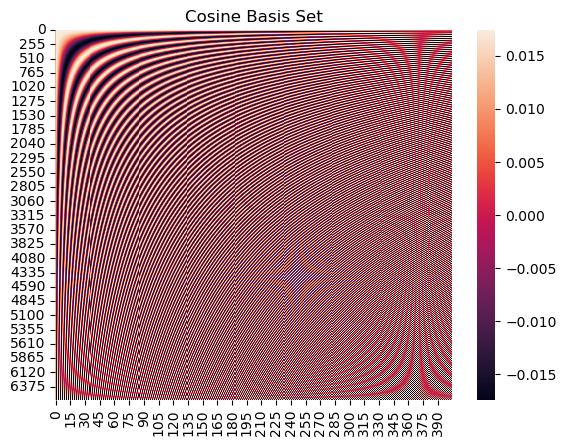

In [12]:
sns.heatmap(xb);
plt.title('Cosine Basis Set');

In [31]:
# Create Nilearn HRF with specified microtime resolution
time_length = 32
dt = TR/NT
frame_times = np.linspace(0, time_length, int(time_length/dt+1))
onset, amplitude, duration = 0.0, 1.0, dt
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

nilearn_hrf = compute_regressor(exp_condition,"spm",frame_times,con_id="main")[0]

In [38]:
TR/NT, TR

(0.045, 0.72)

In [39]:
Hxb = np.zeros((N,N))

for i in range(N):
    Hxb[:,i] = np.squeeze(convolve(xb[:,i].reshape(-1,1),nilearn_hrf)[1+128:N*NT+128:NT])


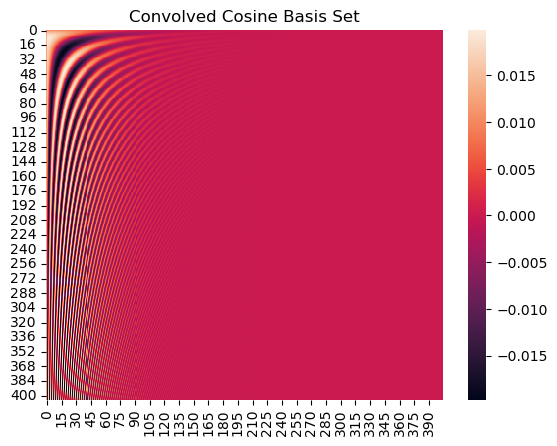

In [15]:
sns.heatmap(Hxb);
plt.title('Convolved Cosine Basis Set');

In [26]:
Hxb[20:24,20]

array([-0.01924196, -0.01914697, -0.01858939, -0.01758452])

In [16]:
# Alpha = 0 (ridge regression reduces to ordinary least-squares (OLS) method)
reg_alpha_0 = Ridge(alpha=0,solver='lsqr',fit_intercept=False,max_iter=1000)
reg_alpha_0.fit(Hxb,data['preproc_BOLD_signal'])

Ridge(alpha=0, fit_intercept=False, max_iter=1000, solver='lsqr')

In [17]:
# Alpha = 1
reg_alpha_1 = Ridge(alpha=1,solver='lsqr',fit_intercept=False,max_iter=1000)
reg_alpha_1.fit(Hxb,data['preproc_BOLD_signal'])

Ridge(alpha=1, fit_intercept=False, max_iter=1000, solver='lsqr')

In [19]:
# Alpha = 0.01
reg_alpha_01 = Ridge(alpha=0.01,solver='lsqr',fit_intercept=False,max_iter=1000)
reg_alpha_01.fit(Hxb,data['preproc_BOLD_signal'])

Ridge(alpha=0.01, fit_intercept=False, max_iter=1000, solver='lsqr')

In [18]:
# Alpha = 0.005
reg_alpha_005 = Ridge(alpha=0.005,solver='lsqr',fit_intercept=False,max_iter=1000)
reg_alpha_005.fit(Hxb,data['preproc_BOLD_signal'])

Ridge(alpha=0.005, fit_intercept=False, max_iter=1000, solver='lsqr')

In [20]:
neuronal_alpha_0 = np.matmul(xb[128:N*NT+128,:],reg_alpha_0.coef_[0,:N])
neuronal_alpha_1 = np.matmul(xb[128:N*NT+128,:],reg_alpha_1.coef_[0,:N])
neuronal_alpha_01 = np.matmul(xb[128:N*NT+128,:],reg_alpha_01.coef_[0,:N])
neuronal_alpha_005 = np.matmul(xb[128:N*NT+128,:],reg_alpha_005.coef_[0,:N])

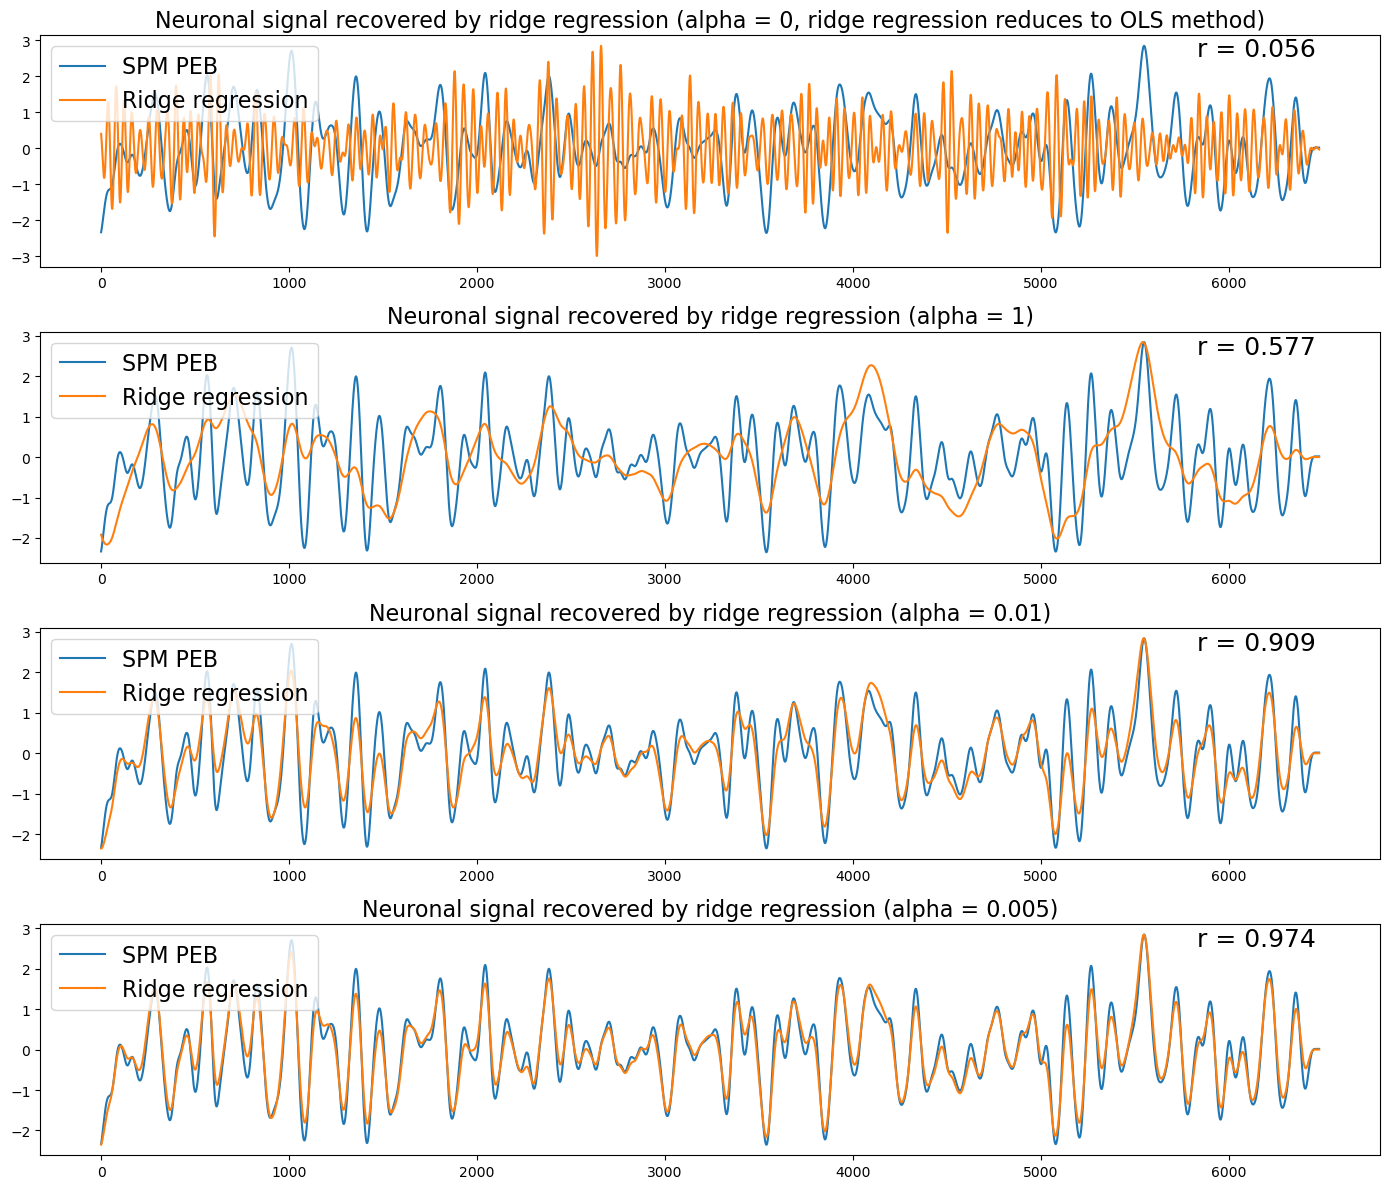

In [21]:
figure(figsize=(14, 12))

plt.subplot(4,1,1)
plt.title('Neuronal signal recovered by ridge regression (alpha = 0, ridge regression reduces to OLS method)', fontsize = 16)
plt.plot(data['spm_phys_neuro'], label = 'SPM PEB')
plt.plot(neuronal_alpha_0/np.max(neuronal_alpha_0)*np.max(data['spm_phys_neuro']), label = 'Ridge regression')
plt.legend(loc = 2, fontsize = 16)
plt.text(N*NT*0.9, np.max(data['spm_phys_neuro'])*0.9, 'r = ' + str(round(pearsonr(np.squeeze(np.asarray(neuronal_alpha_0.reshape(-1,1))),np.squeeze(np.asarray(data['spm_phys_neuro'].reshape(-1,1))))[0],3)), fontsize=18)

plt.subplot(4,1,2)
plt.title('Neuronal signal recovered by ridge regression (alpha = 1)', fontsize = 16)
plt.plot(data['spm_phys_neuro'], label = 'SPM PEB')
plt.plot(neuronal_alpha_1/np.max(neuronal_alpha_1)*np.max(data['spm_phys_neuro']), label = 'Ridge regression')
plt.legend(loc = 2, fontsize = 16)
plt.text(N*NT*0.9, np.max(data['spm_phys_neuro'])*0.9, 'r = ' + str(round(pearsonr(np.squeeze(np.asarray(neuronal_alpha_1.reshape(-1,1))),np.squeeze(np.asarray(data['spm_phys_neuro'].reshape(-1,1))))[0],3)), fontsize=18)


plt.subplot(4,1,3)
plt.title('Neuronal signal recovered by ridge regression (alpha = 0.01)', fontsize = 16)
plt.plot(data['spm_phys_neuro'], label = 'SPM PEB')
plt.plot(neuronal_alpha_01/np.max(neuronal_alpha_01)*np.max(data['spm_phys_neuro']), label = 'Ridge regression')
plt.legend(loc = 2, fontsize = 16)
plt.text(N*NT*0.9, np.max(data['spm_phys_neuro'])*0.9, 'r = ' + str(round(pearsonr(np.squeeze(np.asarray(neuronal_alpha_01.reshape(-1,1))),np.squeeze(np.asarray(data['spm_phys_neuro'].reshape(-1,1))))[0],3)), fontsize=18)


plt.subplot(4,1,4)
plt.title('Neuronal signal recovered by ridge regression (alpha = 0.005)', fontsize = 16)
plt.plot(data['spm_phys_neuro'], label = 'SPM PEB')
plt.plot(neuronal_alpha_005/np.max(neuronal_alpha_005)*np.max(data['spm_phys_neuro']), label = 'Ridge regression')
plt.legend(loc = 2, fontsize = 16)
plt.text(N*NT*0.9, np.max(data['spm_phys_neuro'])*0.9, 'r = ' + str(round(pearsonr(np.squeeze(np.asarray(neuronal_alpha_005.reshape(-1,1))),np.squeeze(np.asarray(data['spm_phys_neuro'].reshape(-1,1))))[0],3)), fontsize=18)

plt.tight_layout()
plt.show()


In [42]:
dctmtx(10,20)

array([[ 3.16227766e-01,  4.47213595e-01,  4.47213595e-01,
         4.47213595e-01,  4.47213595e-01,  4.47213595e-01,
         4.47213595e-01,  4.47213595e-01,  4.47213595e-01,
         4.47213595e-01,  4.47213595e-01,  4.47213595e-01,
         4.47213595e-01,  4.47213595e-01,  4.47213595e-01,
         4.47213595e-01,  4.47213595e-01,  4.47213595e-01,
         4.47213595e-01,  4.47213595e-01],
       [ 3.16227766e-01,  4.25325404e-01,  3.61803399e-01,
         2.62865556e-01,  1.38196601e-01,  2.73839349e-17,
        -1.38196601e-01, -2.62865556e-01, -3.61803399e-01,
        -4.25325404e-01, -4.47213595e-01, -4.25325404e-01,
        -3.61803399e-01, -2.62865556e-01, -1.38196601e-01,
        -8.21518047e-17,  1.38196601e-01,  2.62865556e-01,
         3.61803399e-01,  4.25325404e-01],
       [ 3.16227766e-01,  3.61803399e-01,  1.38196601e-01,
        -1.38196601e-01, -3.61803399e-01, -4.47213595e-01,
        -3.61803399e-01, -1.38196601e-01,  1.38196601e-01,
         3.61803399e-01,  4.4